In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import scipy.linalg as sp_la
from sklearn import metrics

# Overall Review <a class="anchor" id="review"></a>


Today we are going to load a dataset and use it to review each type of data analysis method we have looked at this semester.

*NB* I guarantee there are bugs in the code, and quite likely errors or gaps in the descriptions. Comments welcome!

### Table of Contents

* [Prepare Your Data](#prepData)
    * [Load Your Data](#loadData)
    * [Look At Your Data](#lookData)
    * [Clean Your Data](#cleanData)
    * [Split Your Data](#splitData)
    * [Transform/Normalize Your Data](#normalizeData)
    * [Reduce The Dimensionality of Your Data](#pcaData)
    * [Summary](#summaryData)
* [Model](#model)
    * [Distance Metrics](#distances)
    * [Regression](#regression)
      * [Types](#regressionTypes)
      * [Distance Metrics](#regressionDistance)
      * [Loss Function](#regressionLoss)
      * [Methods](#regressionMethods)
        * [Least Squares](#leastSquares)
        * [Normal Equation](#normalEquation)
        * [QR Decomposition](#qrDecomposition)
        * [Gradient Descent](#gradientDescent)
        * [Stepwise](#stepwiseRegression)
        * [RBF Networks](#regressionRBF)
      * [Evaluation and Visualization](#regressionEvaluation)
      * [Hyperparameters](#regressionHyperparameters)
    * [Clustering](#clustering)
      * [Distance Metrics](#clusteringDistance)
      * [Loss Function](#clusteringLoss)
      * [Methods](#clusteringMethods)
        * [K Means](#kmeans)
      * [Evaluation and Visualization](#clusteringEvaluation)
      * [Hyperparameters](#clusteringHyperparameters)
      * [Example](#clusteringExample)
    * [Classification](#classification)
      * [Distance Metrics](#classificationDistance)
      * [Loss Function](#classificationgLoss)
      * [Methods](#classificationMethods)
        * [K Nearest Neighbors](#knn)
        * [Naive Bayes](#nb)
        * [RBF Networks](#classificationRBF)
      * [Evaluation and Visualization](#classificationEvaluation)
      * [Hyperparameters](#classificationHyperparameters)
      * [Probability Distributions](#classificationProbabilityDistributions)
      * [Example](#classificationExample)
  * [RBF Networks](#rbfNetworks)
    * [Example For Regression](#rbfRegression)
    * [Example For Classification](#rbfClassification)

# Prepare Your Data <a class="anchor" id="prepData"></a>

## Load Your Data <a class="anchor" id="loadData"></a>

* Where does the data come from?
* Are there any ethical concerns with using this data?

## Look At Your Data <a class="anchor" id="lookData"></a>

* How many data points are there?
* How many variables are there?
* What is the type of each variable?
* Are the variables independent of each other?
* Is there a value for each variable for each data point?
* Do the values make sense?

Visualizations useful for looking at your data include:
* histograms
* scatter plots
* pair plots

It's important that visualizations be:
* clear
* color blind friendly
* labeled

In [8]:
def getSummaryStatistics(data):
    "Get the max, min, mean, var for each variable in the data."
    return pd.DataFrame(np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0), data.var(axis=0)]))

## If There Are Missing/Erroneous/Mistyped Values, Clean Your Data <a class="anchor" id="cleanData"></a>

If your data is *unordered*:
* You can fill in missing values using the mean or median (quantitative variable) or mode (qualitative variable)

If your data is *ordered*:
* Use interpolation or fill-forward

You can also *delete* data points with missing or erroneous values, but be careful.

See https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf for more information. 

## If You Intend to Perform Regression or Classification Experiments, Split Your Data <a class="anchor" id="splitData"></a>

* Into train, dev, test
* And identify and split off the dependent variable
* Make sure that the (labels and) data distributions are the same across train, dev and test
  * You may have to use stratified sampling

In [9]:
# Random shuffle
def randomSplit(data, depVar, indVars):
    np.random.shuffle(data)
    train, dev, test = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])
    train, trainY = train[np.ix_(np.arange(train.shape[0]), indVars)], train[:, depVar]
    dev, devY = dev[np.ix_(np.arange(dev.shape[0]), indVars)], dev[:, depVar]
    test, testY = test[np.ix_(np.arange(test.shape[0]), indVars)], test[:, depVar]
    return train, dev, test, trainY, devY, testY

# Stratified sampling
def stratifiedSplit(data, depVar, indVars, numberValsToKeep=-1):
    if numberValsToKeep > -1:
        byCategory = [data[data[:,-1]==k] for k in np.unique(data[:,-1])][0:numberValsToKeep]
    else:
        byCategory = [data[data[:,-1]==k] for k in np.unique(data[:,-1])]
    print(len(byCategory))

    trainFeats = []
    devFeats = []
    testFeats = []
    trainYs = []
    devYs = []
    testYs = []
    for category in byCategory:
        train, dev, test = np.split(category, [int(.8 * len(category)), int(.9 * len(category))])
        train, trainY = train[np.ix_(np.arange(train.shape[0]), indVars)], train[:, depVar]
        dev, devY = dev[np.ix_(np.arange(dev.shape[0]), indVars)], dev[:, depVar]
        test, testY = test[np.ix_(np.arange(test.shape[0]), indVars)], test[:, depVar]
        trainFeats.append(train)
        devFeats.append(dev)
        testFeats.append(test)
        trainYs.append(trainY)
        devYs.append(devY)
        testYs.append(testY)
    return np.vstack(trainFeats), np.vstack(devFeats), np.vstack(testFeats), np.concatenate(trainYs), np.concatenate(devYs), np.concatenate(testYs)

## Consider Transforming/Normalizing the Data <a class="anchor" id="normalizeData"></a>

You might want to transform your data:
* in order to visualize it better / more easily - scale, rotate, min-max, zscore
* in order to remove the outsize impact of some variables having larger range than others - min-max, zscore
* in order to center the data for PCA - translate

Types of transformation include:
* translation: in 3d, x by $\alpha$, y by $\beta$, z by $\gamma$:
  * you need to add a homogenous coordinate to your data - a trailing column of 1s
  * the transformation matrix looks like $$\begin{pmatrix} 1 & 0 & 0 & \alpha \\ 0 & 1 & 0 & \beta \\ 0 & 0 & 1 & \gamma \end{pmatrix}$$
* scaling: in 3d, x by $\delta$, y by $\zeta$, z by $\kappa$
  * the transformation matrix looks like $$\begin{pmatrix} \delta & 0 & 0  \\ 0 & \zeta & 0 \\ 0 & 0 & \kappa \end{pmatrix}$$
* rotation: 
  * in 2d, by $\theta$ radians: $$\begin{pmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta)  \end{pmatrix}$$
  * in 3d:
    * around the x-axis, by $\theta$ radians: $$\begin{pmatrix} 1 & 0 & 0  \\ 0 & cos(\theta) & -sin(\theta) \\ 0 & sin(\theta) & cos(\theta)  \end{pmatrix}$$
    * around the y-axis, by $\theta$ radians: $$\begin{pmatrix} cos(\theta) & 0 & sin(\theta)  \\ 0 & 1 & 0 \\ -sin(\theta) & 0 & cos(\theta) \end{pmatrix}$$
    * around the z-axis, by $\theta$ radians: $$\begin{pmatrix} cos(\theta) & -sin(\theta) & 0 \\ sin(\theta) & cos(\theta) & 0 \\ 0 & 0 & 1 \end{pmatrix}$$

and these combinations of translation + scaling:
* min-max global: divide each data point by (max-min) 
* min-max local: divide each data point by (max-min) *for that feature*
* zscoring: subtract the per-feature mean from each data point and divide by the per-feature standard deviation 

In [10]:
def homogenizeData(data):
    return np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
   
# yaw
def rotateTransformX(x):
    return np.array([1, 0, 0, 0, np.cos(np.radians(x)), -np.sin(np.radians(x)), 0, np.sin(np.radians(x)), np.cos(np.radians(x))]).reshape(3, 3)

# pitch
def rotateTransformY(y):
    return np.array([np.cos(np.radians(y)), 0, np.sin(np.radians(y)), 0, 1, 0, -np.sin(np.radians(y)), 0, np.cos(np.radians(y))]).reshape(3, 3)

# roll
def rotateTransformZ(z):
    return np.array([np.cos(np.radians(z)), -np.sin(np.radians(z)), 0, np.sin(np.radians(z)), np.cos(np.radians(z)), 0, 0, 0, 1]).reshape(3, 3)

def minmaxGlobal(data):
    "Global max-min normalization."
    scaleTransform = np.eye(data.shape[1], data.shape[1])
    for i in range(data.shape[1]):
        scaleTransform[i, i] = 1 / (data.max() - data.min())
    return (scaleTransform@data.T).T

def minmaxLocal(data):
    "Local max-min normalization."
    scaleTransform = np.eye(data.shape[1], data.shape[1])
    for i in range(data.shape[1]):
        if data[:, i].max() - data[:, i].min() != 0:
            scaleTransform[i, i] = 1 / (data[:, i].max() - data[:, i].min())
    return (scaleTransform@data.T).T

def zScore(data, translateTransform=None, scaleTransform=None):
    "z score."
    homogenizedData = np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
    if translateTransform is None:
        translateTransform = np.eye(homogenizedData.shape[1])
        for i in range(homogenizedData.shape[1]):
            translateTransform[i, homogenizedData.shape[1]-1] = -homogenizedData[:, i].mean()
    if scaleTransform is None:
        diagonal = [1 / homogenizedData[:, i].std() if homogenizedData[:, i].std() != 0 else 1 for i in range(homogenizedData.shape[1])]
        scaleTransform = np.eye(homogenizedData.shape[1], dtype=float) * diagonal
    data = (scaleTransform@translateTransform@homogenizedData.T).T
    return translateTransform, scaleTransform, data[:, :data.shape[1]-1]

## Consider Dimensionality Reduction <a class="anchor" id="pcaData"></a>

For dimensionality reduction we use principal components analysis (PCA). 

A PCA model is fit on top of the *covariance matrix* for a dataset. The covariance matrix tells us about the first order relationships between different features. If $A$ is the matrix corresponding to our data set of $N$ data points for each of which we have $M$ features, and $\bar{A_i}$ is the mean of the $i$th feature, then covariance matrix $C$ is:
    $$C_{i,j} = \sum_{k=1}^N \frac{(A_{k,i} - \bar{A_i})(A_{k,j} - \bar{A_j})}{N-1}$$
    
The covariance matrix has the variance of each feature along its diagonal, and the remaining entries are the *covariances* of pairs of features, ie how much they vary together. If they vary together, then they are related to each other - some information is shared between them.

The steps to fit a PCA are:
* (If appropriate) normalize the variables to be in the range 0-1
* Center the data
* Compute the covariance matrix
* Compute the eigenvectors and eigenvalues; the eigenvectors tell us the direction of variance, and the eigenvalues tell us the amount of variance
* Get an ordering over the eigenvalues
* Sort the eigenvalues and eigenvectors accordingly
* Compute the proportional variance (how much bigger?) accounted for by each principal component
* Compute the cumulative sum of the proportional variance (tells us how many eigenvectors we need to explain a desired amount of variance)
* Examine the principal components. Select v' of them.
* Project the data into PCA space
* Reconstruct the data

Visualizations helpful for examining the covariance matrix are:
* heatmap

Visualizations useful for examining the output of a PCA to determine how many principal components to keep are:
* elbow plot
* scree plot

In [11]:
class PCA:
    def __init__(self, centered=False, plot=False):
        self.eigenvalues = None
        self.eigenvectors = None
        self.principalComponents = 0
        self.centered = centered
        self.plot = plot
    
    def fit(self, data):
        # center
        if not self.centered:
            data = data - np.mean(data, axis=0)

        # covariance
        covarianceMatrix = (data.T @ data) / (data.shape[0] - 1)
        if self.plot:
            sns.heatmap(pd.DataFrame(covarianceMatrix), annot=False, cmap='PuOr')
            plt.title("Covariance Matrix")
            plt.show()

        # svd
        (evals, evectors) = np.linalg.eig(covarianceMatrix)

        # sort
        evalsOrder = np.argsort(evals)[::-1]
        self.eigenvalues = evals[evalsOrder]
        self.eigenvectors = evectors[:, evalsOrder]

        # proportional variance
        evalsSum = np.sum(self.eigenvalues)
        proportionalVars = [e / evalsSum for e in self.eigenvalues]

        # cumulative sum of proportional variance
        cumulativeSum = np.cumsum(proportionalVars)

        if self.plot:
            plt.figure(figsize=(6, 4))
            plt.bar(range(len(proportionalVars)), proportionalVars, alpha=0.5, align='center',
                    label='Proportional variance')
            plt.xticks(list(range(len(proportionalVars))))
            plt.ylabel('Proportional variance ratio')
            plt.xlabel('Ranked Principal Components')
            plt.title("Scree Graph")
            plt.show()

            plt.figure(figsize=(6,4))
            plt.plot(range(len(cumulativeSum)), cumulativeSum)
            plt.ylim((0,1.1))
            plt.xlabel('Number of Principal Components')
            plt.ylabel('Cumulative explained variance')
            plt.title('Elbow Plot')
            plt.show()

    def project(self, data, numberOfComponents):
        self.principalComponents = numberOfComponents
        # center
        if not self.centered:
            data = data - np.mean(data, axis=0)
        v = self.eigenvectors[:, :numberOfComponents]
        projected = data@v
        return projected

## All Together <a class="anchor" id="summaryData"></a>

In [12]:
def convertLabel(label):
    labels = {'SEKER': 0, 'BARBUNYA': 1, 'BOMBAY': 2, 'CALI': 3, 'HOROZ': 4, 'SIRA': 5, 'DERMASON': 6}
    return float(labels[str(label)])

def prepData(type="regression", depVar=0, fractionToKeep=1.0):
    # Load the data
    print("\nLoad the data")
    columns = ['area', 'perimeter', 'major_axis_length', 'minor_axis_length', 'aspect_ratio', 'eccentricity', 'convex_area', 'equivalent_diameter', 'extent', 'solidity', 'roundness', 'compactness', 'shapefactor1', 'shapefactor2', 'shapefactor3', 'shapefactor4', 'class']
    # This dataset comes from https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset and the data sheet is there
    data = np.array(np.genfromtxt('data/Dry_Bean_Dataset.arff', delimiter=',', converters={16: convertLabel}, skip_header=25, dtype=float, encoding='utf-8')) 

    # Look at the data
    print("\nInspect the data")
    print("data shape\n", data.shape, "\ndata type\n", data.dtype)
    print("data max, min, mean, var\n", getSummaryStatistics(data))
    sns.pairplot(pd.DataFrame(data, columns=columns), y_vars = ["class"], x_vars = ['area', 'perimeter', 'major_axis_length', 'minor_axis_length', 'aspect_ratio'], kind = "scatter")
    sns.pairplot(pd.DataFrame(data, columns=columns), y_vars = ["class"], x_vars = ['eccentricity', 'convex_area', 'equivalent_diameter', 'extent', 'solidity'], kind = "scatter")
    sns.pairplot(pd.DataFrame(data, columns=columns), y_vars = ["class"], x_vars = ['roundness', 'compactness', 'shapefactor1', 'shapefactor2', 'shapefactor3', 'shapefactor4'], kind = "scatter")
    plt.show()

    # Clean the data
    print("\nClean the data")
    ## No missing values

    if depVar > -1:
        # Set the dependent and independent variables
        indVars = list(range(data.shape[1]))
        indVars.pop(depVar)
        depName = columns.pop(depVar)
        # Split the data, reducing it if necessary
        print("\nSplit the data, dependent variable ", depVar, ", to keep ", fractionToKeep)
        train, dev, test, trainY, devY, testY = stratifiedSplit(data, depVar, indVars, numberValsToKeep=fractionToKeep)
        print("training data shape", "\n", train.shape, "\ntraining data max, min, mean, var\n", getSummaryStatistics(train))
        print("\ndev data shape", "\n", dev.shape, "\ndev data max, min, mean, var\n", getSummaryStatistics(dev))
        print("\ntest data shape", "\n", test.shape, "\ntest data max, min, mean, var\n", getSummaryStatistics(test))
        # Transform the data
        print("\nTransform the data")
        translateTransform, scaleTransform, trainTransformed = zScore(train)
        print("training data shape", "\n", trainTransformed.shape, "\ntraining data max, min, mean, var\n", getSummaryStatistics(trainTransformed))
        _, _, devTransformed = zScore(dev, translateTransform=translateTransform, scaleTransform=scaleTransform)
        print("\ndev data shape", "\n", devTransformed.shape, "\ndev data max, min, mean, var\n", getSummaryStatistics(devTransformed))
        _, _, testTransformed = zScore(test, translateTransform=translateTransform, scaleTransform=scaleTransform)
        print("\ntest data shape", "\n", testTransformed.shape, "\ntest data max, min, mean, var\n", getSummaryStatistics(testTransformed))
        return trainTransformed, devTransformed, testTransformed, trainY, devY, testY
    else:
        # Reduce the data if necessary
        if fractionToKeep < 1.0:
            print("\nReducing the data by", (1.0-fractionToKeep))
            data, _ = np.split(data, [int(fractionToKeep*len(data))])
        # Transform the data
        print("\nTransform the data")
        print("data shape", "\n", data.shape, "\ndata max, min, mean, var\n", getSummaryStatistics(data))
        translateTransform, scaleTransform, transformed = zScore(data)
        print("data shape", "\n", transformed.shape, "\ndata max, min, mean, var\n", getSummaryStatistics(transformed))
        return transformed
    
def projectData(data, principalComponents, *args):
    # Dimensionality reduction
    print("\nDo PCA on the data, keep principal components")
    pca = PCA(centered=True, plot=True)
    pca.fit(data)
    projected = pca.project(data, principalComponents)
    return projected, [pca.project(arg, principalComponents) for arg in args]

[Go back to the top](#review)


# Model <a class="anchor" id="model"></a>

There are several basic types of ML model:
* regression
* clustering
* classification

Data is a good fit for:
* regression - if the dependent variable is *ordered* - quantitative continuous, quantitative discrete or (at a stretch) qualitative ordinal
* clustering - if you have no dependent variable, but want to understand the structure of your data better
* classification - if the dependent variable is *qualitative*

No matter what modeling approach you use, you will want to define:
* a distance metric - between data points
* a loss function - something to optimize (typically a loss function is defined in terms of the distance metric)
* a way to evaluate, examine or visualize the model output

Different model architectures may have additional *hyperparameters*.

## Distance Metrics <a class="anchor" id="distances"></a>

Commonly used distance metrics are:
* Euclidean (L2 norm): $d(\vec{a}, \vec{b}) = \sqrt{\sum_{i=1}^m (a_i - b_i)^2}$
  * We write this as $||\vec{a} - \vec{b}||_2$.
* Manhattan (L1 norm): $d(\vec{a}, \vec{b}) = \sum_{i=1}^m |a_i - b_i|$
  * We write this as $||\vec{a} - \vec{b}||_1$.
* Chebyshev distance (L$^\infty$ norm): $d(\vec{a}, \vec{b}) = max_i |a_i - b_i|$
  * We write this as $||\vec{a}, \vec{b}||_\infty$.
* Minkowski distance (L$^p$ norm):  $d(\vec{a}) = \left[
\sum_{i=1}^m |a_i|^p
\right]^{1/p}$
  * We write this as $||\vec{a}||_p$.
  
However, there are a lot more than this: Hamming distance, cosine distance, Levenshtein distance....

## Regression <a class="anchor" id="regression"></a>

### Types <a class="anchor" id="regressionTypes"></a>

We know three types of regression:
* Linear regression - fit a line through 2d data
* Multiple linear regression - fit a plane through 3d+ data
* Polynomial regression - fit a curve through 2d data
  * If you want to do multivariate polynomial regression in pure python, check out https://github.com/sigvaldm/localreg

### Distance Metric  <a class="anchor" id="regressionDistance"></a>

The standard metric used for regression is Euclidean distance.

### Loss Function  <a class="anchor" id="regressionLoss"></a>

The loss function is MSSE (mean sum squared error): $$MSSE = 1 / N \sum_{i=1}^N (r_i)^2 = 1/N \sum_{i=1}^N (y_i - \hat{y}_i)^2$$. The Euclidean distance is embedded in there.

### Methods  <a class="anchor" id="regressionMethods"></a>

We know six methods for fitting a regression. All these methods minimize MSSE.

#### Least squares <a class="anchor" id="leastSquares"></a>

$\vec{y} = b + m x_i = (1, X_i) \cdot (b, m)$, or $\vec{y} = A \cdot \vec{c}$

This can be computationally expensive to calculate.

#### Normal equation <a class="anchor" id="normalEquation"></a>

The normal equation is $ \vec{c} = (A^TA)^{-1} A^T\vec{y}$.

If $A^TA$ is not invertible we can't use the normal equation. Use one of the other methods, or remove some variables that are not independent of each other.

Calculating $A^TA$ is computationally expensive.

#### QR decomposition <a class="anchor" id="qrDecomposition"></a>

$R \vec{c} = Q^T \vec{y}  $, where $A = QR$
* $Q$ is orthonormal, which means that $Q^TQ = I$, which means that $Q^T = Q^{-1}$.
* We calculate $Q$ using Gram-Schmidt decomposition.
* $R$ is upper triangle, so we can use back substitution to solve.

If $A$ does not have linearly independent columns, QR decomposition won't work.

#### Gradient descent <a class="anchor" id="gradientDescent"></a>

Unlike the other methods, which are analytical, this is an approximation method.

This method is an iterative step by step method. We take a step, figure out if we are going towards the *minimum loss* and if so we take another step. 
* At first we pick random values for $m$ and $b$ (our slope and intercept).
* At each step we:
  1. calculate the partial derivative of $MSSE$ with respect to $m$ and to $b$, and plug in $x$, $y$, $m$ and $b$.
    * partial derivative of $MSSE$ ($p$) with respect to $m$: $$\frac{\partial p}{\partial m} = 1/N \sum_{i=1}^N \frac{\partial }{\partial m} (y_i - \hat{y}_i)^2 = 1/N \sum_{i=1}^N \frac{\partial }{\partial m} (y_i - (m x_i + b))^2 = 1 / N \sum_{i=1}^N -2 x_i (y_i - (m x_i + b)) = -2 / N \sum_{i=1}^N x_i (y_i - \hat{y}_i)$$
    * partial derivative of $MSSE$ ($p$) with respect to $b$: $$\frac{\partial p}{\partial b} = 1/N \sum_{i=1}^N \frac{\partial }{\partial b} (y_i - \hat{y}_i)^2 = 1/N \sum_{i=1}^N \frac{\partial }{\partial b} (y_i - (m x_i + b))^2 = 1 / N \sum_{i=1}^N -2 (y_i - (m x_i + b)) = -2 / N \sum_{i=1}^N (y_i - \hat{y}_i)$$
  2. update $m$ and $b$ as follows:
    * $m = m - lr * \frac{\partial p}{\partial m}$
    * $b = b - lr * \frac{\partial p}{\partial b}$
    where $lr$ is a *learning rate* set, hopefully, big enough that we don't have to step forever, and small enough that we don't overshoot our goal (the minimum loss).
* We stop after a preset number of steps (*epochs*) or after the change in loss stops getting smaller.

#### Stepwise regression <a class="anchor" id="stepwiseRegression"></a>

This method can be used with the others. It is useful when you have many features and you want to know which ones work.

For stepwise regression, we use ${R^2}_{adj} = 1 - \frac{(1-R^2)(N-1)}{N-k-1}$
where $N$ is the number of variables, and $k$ is the number of variables in $A$.

Stepwise regression works like this:
1. Initialize $A$ to be just the leading column of 1s (because we know we will have an intercept).
2. Then while the improvements in ${R^2}_{adj}$ are > 0 and there remain independent variables not yet added:
  * calculate a regression using $A$ and each variable not yet in $A$, and 
  * add the one with the highest ${R^2}_{adj}$ to $A$.
  
#### RBF networks <a class="anchor" id="regressionRBF"></a>

See RBF networks, below.

### Evaluation and Visualization  <a class="anchor" id="regressionEvaluation"></a>

The evaluation metric is $R^2$: $R^2 = 1 - \frac{\sum_{i=1}^N (y_i - \hat{y})^2}{\sum_{i=1}^N (y_i - \bar{y})^2} = 1 - \frac{r_i^2}{\sum_{i=1}^N (y_i - \bar{y})^2}$. This measures the goodness of fit of the regression.

### Hyperparameters  <a class="anchor" id="regressionHyperparameters"></a>

The hyperparameter for regression is the polynomial degree of the regression.

In [13]:
class LinearRegression:
    def __init__(self):
        self.slopesIntercept = None
    
    def fitlstsq(self, data, y):
        "Fit a linear regression using least squares."
        # We add a column of 1s for the intercept
        A = np.hstack((np.array([np.ones(data.shape[0])]).T, data))
        # This is the regression coefficients that were fit, plus some other results
        self.slopesIntercept, _, _, _ = sp_la.lstsq(A, y)

    def fitnorm(self, data, y):
        "Fit a linear regression using the normal equation."
        # We add a column of 1s for the intercept
        A = np.hstack((np.array([np.ones(data.shape[0])]).T, data))
        # This is the regression coefficients that were fit, plus some other results
        self.slopesIntercept = sp_la.inv(A.T.dot(A)).dot(A.T).dot(y)

    def fitqr(self, data, y):
        "Fit a linear regression using QR decomposition."
        # We add a column of 1s for the intercept
        A = np.hstack((np.array([np.ones(data.shape[0])]).T, data))
        # This is the regression coefficients that were fit, plus some other results
        Q, R = sp_la.qr(A)
        self.slopesIntercept = sp_la.solve_triangular(R, Q.T.dot(y))

    def gradient_descent(self, data, y, lr, epochs):
        "Fit a linear regression using gradient descent."
        # initialize m and b
        rng = default_rng()
        # possibly this should not be fixed at 2
        self.slopesIntercept = rng.standard_normal(2)
        A = np.hstack((np.array([np.ones(data.shape[0])]).T, data))
        for i in range(epochs):
            yhat = np.dot(A, self.slopesIntercept)
            if self.msse(y, yhat) < 0.00001:
                return
            # fill in the partial derivatives
            dpdm = (-2/n) * np.sum(x * (y - yhat))
            dpdb = (-2/n) * np.sum(y - yhat)
            # update c
            self.slopesIntercept = self.slopesIntercept - np.array([lr * dpdm, lr * dpdb])
    
    def msse(self, y, yhat):
        "Calculate MSSE."
        if len(y) != len(yhat):
            print("Need y and yhat to be the same length!")
            return 0
        return (1 / len(y)) * (((y - yhat())**2).sum())

    def rsquared(self, y, yhat):
        "Calculate R^2."
        if len(y) != len(yhat):
            print("Need y and yhat to be the same length!")
            return 0
        return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

    def predict(self, data):
        "Given a linear regression function, predict on new data."
        # We add a column of 1s for the intercept
        A = np.hstack((np.array([np.ones(data.shape[0])]).T, data))
        return np.dot(A, self.slopesIntercept)


In [14]:
class PolynomialRegression:
    "Polynomial regression with one independent variable only."
    def __init__(self):
        self.poly = 0
        self.slopesIntercept = None
    
    def makePoly(self, data):
        A = np.zeros([data.shape[0], self.poly+1])
        for i in range(0, self.poly+1):
            A[:, i] = np.squeeze(data**i)
        print(getSummaryStatistics(A))
        print(getShapeType(A))
        return A

    def fitlstsq(self, data, y, poly):
        self.poly = poly
        # We add a column of 1s for the intercept
        A = makePoly(data)
        # This is the regression coefficients that were fit, plus some other results
        self.slopesIntercept, _, _, _ = sp_la.lstsq(A, y)

    def predict(self, data):
        # We add a column of 1s for the intercept
        A = makePoly(data, self.poly)
        return np.dot(A, self.slopesIntercept)
    
    def rsquared(self, y, yhat):
        "Calculate R^2."
        if len(y) != len(yhat):
            print("Need y and yhat to be the same length!")
            return 0
        return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

[Go back to the top](#review)

### A Worked Example <a class="anchor" id="regressionExample"></a>

Why would we not fit a regression on the raw data?

Which is better, fitting a linear regression on the transformed data or on the projected data?

Which is more efficient?

In [ ]:
transformedTrain, transformedDev, transformedTest, trainY, devY, testY = prepData(type="regression", depVar=0, fractionToKeep=-1)
projectedTrain, projectedDevTest = projectData(transformedTrain, 8, transformedDev, transformedTest)

In [ ]:
%%time

# Linear regression on the transformed data

lr = LinearRegression()
lr.fitlstsq(transformedTrain, trainY)
print(lr.rsquared(lr.predict(transformedDev), devY))

In [ ]:
%%time

# Linear regression on the dimensionality-reduced, projected data

lr.fitlstsq(projectedTrain, trainY)
print(lr.rsquared(lr.predict(projectedDevTest[0]), devY))

[Go back to the top](#review)

## Clustering <a class="anchor" id="clustering"></a>

Clustering algorithms separate a data set into groups, or clusters, that are near each other (similar to each other) using a distance metric we choose or define.

We can use clustering methods for data exploration and for data compression.

### Distance Metric <a class="anchor" id="clusteringDistance"></a>

If you have used PCA to do dimensionality reduction on your data, you should use Euclidean distance.

Otherwise, you should choose a distance metric relevant to your data. 

### Loss Function  <a class="anchor" id="clusteringLoss"></a>

For k-means clustering, we minimize *inertia*:
$inertia = 1/N \sum_{j=1}^N d(\vec{x_j}, \vec{m_{\vec{x_j}}})^2$, where $\vec{m_{x_j}}$ is the centroid of the cluster that $x_j$ is currently assigned to, and $d$ is your chosen distance metric.

### Methods  <a class="anchor" id="clusteringMethods"></a>

We know one method for clustering.

For a list of lots of clustering algorithms, see https://scikit-learn.org/stable/modules/clustering.html.

#### K-means clustering <a class="anchor" id="kmeans"></a>

To make this computationally efficient, we calculate an approximate solution by iteration:
1. Pick initial centroids.
  * You may pick them at random.
  * Or you may use k-means++:
    1. Choose a single random data point as the first centroid, $\vec{c_1}$.
    2. Repeat til $k$
      1. Calculate the distance between each data point $\vec{x_i}$ and its nearest previously chosen centroid $\vec{c_i}$.
      2. Pick the next centroid according to $p(\vec{x_i}) = \frac{d(\vec{x_i}, \vec{c_i})}{\sum_{j=1}^N d(\vec{x_j}, \vec{c_i})}$. (In python, you can get the index of this next centroid using index = np.random.choice([0, 1, ..., N], p=$p(x_i)$). You can also square the distances in the numerator and denominator above, to spread the distances out further.)
2. For step in range(max_steps):
  1. Assign each point to its closest centroid.
  2. Pick new centroids using the members in each cluster. If the centroids don't change, then return.
  
This method is guaranteed to converge as at each round the inertia will decrease or stay the same, and if it stays the same you halt.

It is important to normalize your data before k-means clustering, or the variable with the widest range will dominate.

### Evaluation and Visualization  <a class="anchor" id="clusteringEvaluation"></a>

An elbow plot of inertia over k is useful for choosing k.

A clustering is really useful insofar as it tells you something interesting about your data. However, there are ways of assessing the "goodness" of a clustering, including:
* Davies–Bouldin index
* Dunn index
* Silhouette coefficient

### Hyperparameters  <a class="anchor" id="clusteringHyperparameters"></a>

The hyperparameters for k-means clustering include:
* the distance metric
* k
* the method for initializing centroids

In [15]:
class KMeans:
    def __init__(self):
        self.centroids = None
        self.clusters = None
        self.k = None

    # Let's define a distance metric; which one is this??
    def distance(self, a, b):
        subtracted = a-b
        return np.sqrt(np.dot(subtracted.T, subtracted))

    # Let's define a function to calculate the distance from each data point to each centroid
    def getDistances(self, item):
        return [self.distance(item, centroid) for centroid in self.centroids]

    # Let's define a function to update cluster assignments given a set of centroids
    def updateClusters(self, data):
        self.clusters = [np.argmin(self.getDistances(item)) for item in data]

    # Let's define a function to update the centroids
    def updateCentroids(self, data):
        withClusters = np.hstack((data, np.array([self.clusters]).T))
        indices = np.argsort(withClusters[:, -1])
        withClustersSorted = withClusters[indices]
        byCluster = np.array_split(withClustersSorted, np.where(np.diff(withClustersSorted[:, -1])!=0)[0]+1)
        self.centroids = np.array([np.mean(cluster[:, :-1], axis=0) for cluster in byCluster])

    # Let's define a function to measure the inertia
    def inertia(self, data):
        sumSquares = 0
        for i in range(len(data)):
            sumSquares += self.distance(data[i], self.centroids[self.clusters[i]])**2
        return sumSquares / len(data)
    
    def pickInitialCentroids(self, data, k, random=True):
        if random:
            self.centroids = np.array([data[x] for x in np.random.choice(np.arange(len(data)), size=k, replace=False)])
        else:
            self.centroids = [data[np.random.randint(len(data))]]
            while len(self.centroids) < k:
                leastDistance = [np.min(self.getDistances(datum))**2 for datum in data]
                p = leastDistance / np.sum(leastDistance)
                self.centroids.append(data[np.random.choice(np.arange(len(leastDistance)),p=p)])
                    
    def fitExplore(self, data, minK, maxK, byK, random=True):
        inertiaByK = []
        for k in range(minK, maxK, byK):
            print(k)
            thisInertia = self.fit(data, k, random=random)
            inertiaByK.append([k, thisInertia])
        fig = plt.figure(figsize=(6,4))
        inertiaByK = np.array(inertiaByK)
        plt.plot(inertiaByK[:, 0], inertiaByK[:, 1])
        plt.xlabel('k')
        plt.ylabel('Inertia')
        plt.title('Elbow Plot')
        plt.show()
            
    def fit(self, data, k, random=False):
        self.k = k
        self.pickInitialCentroids(data, k, random=random)
        self.updateClusters(data)
        thisInertia = self.inertia(data)
        lastInertia = thisInertia + 1
        while abs(lastInertia - thisInertia) > 0.01:
            lastInertia = thisInertia
            self.updateCentroids(data)
            self.updateClusters(data)
            thisInertia = self.inertia(data)
        return thisInertia
    
    def plot(self, data, labels=None):
        if labels is not None:
            sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=self.clusters, style=labels)
            plt.show()
        else:
            sns.scatterplot(data=data, x=data[:, 0], y=data[:, 1], hue=self.clusters)
            plt.show()

[Go back to the top](#review)

## A Worked Example <a class="anchor" id="clusteringExample"></a>

Why would we not fit a k-means clustering on the raw data?

Which is better, fitting a k-means clustering on the transformed data or on the projected data?

Which is more efficient?

In [ ]:
transformedData = prepData(type="clustering", depVar=-1, fractionToKeep=.24)
projectedData, _ = projectData(transformedData, 6)

In [ ]:
%%time

# Clustering on the transformed data, choose k

km = KMeans()
km.fitExplore(transformedData, 2, 40, 2, random=False)

In [ ]:
%%time

# Clustering on the transformed data, best k

km.fit(transformedData, 16, random=False)
km.plot(transformedData)

In [ ]:
%%time

# Clustering on the PCA projected data, choose k

km = KMeans()
km.fitExplore(projectedData, 2, 40, 2, random=False)

In [ ]:
%%time

# Clustering on the PCA projected data, best k

km.fit(projectedData, 10, random=False)
km.plot(projectedData)

[Go back to the top](#review)

# Classification <a class="anchor" id="classification"></a>

Classification algorithms fit a prediction function that can be used to assign a new data point to one of a fixed set of classes.

We know two types of classification:
* binary - there are only two classes
* multiclass - there are three or more classes

### Distance Metric <a class="anchor" id="classificationDistance"></a>

The distance metric is typically Euclidean distance (but it need not be).

### Loss Function <a class="anchor" id="classificationLoss"></a>

The loss function varies by classification model architecture (method).

### Methods <a class="anchor" id="classificationMethods"></a>

We know three methods for classification.

#### K-nearest neighbors <a class="anchor" id="knn"></a>

K-nearest neighbors (KNNs) is a very very simple supervised ML algorithm.
* fit - it just stores all the training data!
* predict - it finds the data points in the training data that are closest to the data point to be classified, and takes a majority vote of their labels.

Loss function for k-nearest-neighbors:
* None. kNN doesn't optimize anything, just stores the training data.

Hyperparameters for k-nearest-neighbors:
* distance metric
* k
* whether to use k-means as preprocessing and then calculate: a) nearest centroid and b) k-nearest-neighbors on elements of cluster defined by nearest centroid

Visualizations that may be helpful:
* elbow plot for choosing k

#### Naive Bayes <a class="anchor" id="nb"></a>

Naive Bayes relies on Bayes rule: $P(Y|X) = \frac{P(Y)*P(X|Y)}{P(X)}$.
* $P(Y|X)$ is the *posterior*
* $P(Y)$ is the *prior*; we approximate this using $\frac{|Y|}{\sum_Y |Y|}$
* $P(X|Y)$ is the *likelihood*; we approximate this using $\frac{|X\&Y|}{|Y|}$
* $P(X)$ is the *evidence* (or *normalization*); we don't need to calculate or approximate this in Naive Bayes since in Naive Bayes we are comparing the posteriors for multiple outcomes and regardless of outcome the denominator is the same

The reason we call it "naive" is because we assume that each independent variable is independent of each other independent variable, so we can use the chain rule to calculate $P(X&Y|Z)$: $P(X&Y|Z) = P(X|Z)*P(Y|Z)$.

To fit a Naive Bayes model:
* Walk over the data and compute a counts table. Each row will correspond to one value for the dependent variable, and each column to one value for an independent variable. Be sure and include row and column totals.
* Walk over the table and calculate:
  * the likelihoods: dividing each value by the total for that row (for that outcome)
  * the priors: dividing the total for each row by the total number of data points

To predict, for each possible variable of the dependent variable, look up the relevant precalculated likelihood and prior and multiply them. Return the value corresponding to the most likely posterior.

Loss function for Naive Bayes:
* None. Basic Naive Bayes doesn't optimize anything, just calculates frequencies over the training data.

Hyperparameters for Naive Bayes:
* Whether or not to smooth the counts of the independent variables to account for the possibility of seeing some new value for an independent variable in the dev or test data. We used Laplace smoothing: for $x_i \in X$:
  * instead of $P(Y|x_i) \sim \frac{|x_i \& Y|}{|Y|}$, 
  * we use $P(Y|x_i) \sim \frac{|x_i \& Y|+1}{|Y| + |x_i|}$. 
* Whether to store raw likelihoods/priors or logs of likelihoods/priors (useful if there are many values for independent variables).
* Whether to use the counts directly, or to use a probability distribution (e.g. Gaussian, Multinomial, Bernoulli) over the data.

Visualizations that may be helpful:
* the counts and likelihoods tables
* confusion matrix (per class)
* ROC curve

#### RBF networks <a class="anchor" id="classificationRBF"></a>

See RBF networks, below.

### Evaluation and Visualization <a class="anchor" id="classificationEvaluation"></a>

For classification, metrics we may report include:
* accuracy
* precision
* recall
* F1

We often display (or plot, as a heat map) a confusion matrix. A confusion matrix shows the true positives, true negatives, false positives and false negatives comparing two classes:
* for binary classification, there are only two classes
* for multiclass classification, confusion matrices may be constructed in one of two ways: one versus others (per class), or one versus one (pairs of classes)

Once we have calculated the confusion matrix, we can easily calculate the true positive rate and false negative rate, and then plot the receiver operating characteristic (ROC) curve and calculate the area under that curve (AUC).

### Hyperparameters <a class="anchor" id="classificationHyperparameters"></a>

The hyperparameters for classification vary by method; see above.

#### Probability Distributions <a class="anchor" id="classificationProbabilityDistributions"></a>

It's important to be able to recognize and think about which probability distribution matches your data.
* Gaussian (normal) - probability density function is $f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$, where $\mu$ is the mean and $\sigma$ is the standard deviation of the data (https://mathworld.wolfram.com/NormalDistribution.html).
![normal distribution](https://upload.wikimedia.org/wikipedia/commons/7/74/Normal_Distribution_PDF.svg)
* Bernoulli - probability density function is $p^n(1-p)^{1-n}$ where $p$ is the probability that an outcome $n=1$ occurs and $1-p$ is the probability that outcome $n=0$ occurs (https://mathworld.wolfram.com/BernoulliDistribution.html).
* Binomial - probability density function is $P_p(n|N) = \binom{N}{n} p^n q^{N-n} = \frac{N!}{n!(N-n)!}p^n(1-p)^{N-n}$, where $n$ is the number of successes out of $N$ trials, and the result of each trial is true with probability $p$ and false with probability $q=1-p$, and $\binom{N}{n}$ is a binomial coefficient (https://mathworld.wolfram.com/BinomialDistribution.html).
![normal vs binomial distributions](https://upload.wikimedia.org/wikipedia/commons/b/b7/Binomial_Distribution.svg)
* Multinomial - the extension of the binomial distribution to the case of multiple random variables (https://mathworld.wolfram.com/MultinomialDistribution.html).

In [ ]:
class Classifier:
    def __init__(self):
        pass

    def predict(self, elements):
        return np.array([self.predictOne(element) for element in elements])
    
    def accuracy(self, y, yhat):
        assert len(y) == len(yhat)
        diffs = y == yhat
        vals, counts = np.unique(diffs, return_counts=True)
        return (counts[np.where(vals == True)] / (np.sum(counts)))[0]
    
    def confusionMatrix(self, y, yhat):
        "Thanks to https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python"
        labelMappings = dict(zip(np.unique(self.labels), range(len(np.unique(self.labels))))) 
        assert len(y) == len(yhat)
        result = np.zeros((len(labelMappings), len(labelMappings)))
        for i in range(len(y)):
            result[labelMappings[y[i]]][labelMappings[yhat[i]]] += 1
        return result
    
    def aucRoc(self, y, yhat):
        "Only works for binary classification"
        auc = metrics.roc_auc_score(y, yhat, multi_class="ovr")
        FPR, TPR, thresholds = metrics.roc_curve(y, yhat)
        plt.figure(figsize=(10, 8), dpi=100)
        plt.axis('scaled')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.title("AUC & ROC Curve")
        plt.plot(FPR, TPR, 'g')
        plt.fill_between(FPR, TPR, facecolor='lightgreen', alpha=0.7)
        plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

    def score(self, elements, labels):
        predictedLabels = self.predict(elements)
        return self.accuracy(labels, predictedLabels), self.confusionMatrix(labels, predictedLabels)

In [ ]:
class KNN(Classifier):
    def __init__(self):
        self.model = None
        self.labels = None
        self.k = 2
        
    def fitExplore(self, train, trainY, dev, devY, minK, maxK, byK):
        accuracyByK = []
        for k in range(minK, maxK, byK):
            print(k)
            self.fit(train, trainY, k)
            devYhat = self.predict(dev)
            accuracyByK.append([k, self.accuracy(devY, devYhat)])
        fig = plt.figure(figsize=(6,4))
        accuracyByK = np.array(accuracyByK)
        plt.plot(accuracyByK[:, 0], accuracyByK[:, 1])
        plt.xlabel('k')
        plt.ylabel('Accuracy')
        plt.title('Elbow Plot')
        plt.show()

    # Let's define fit for kNN
    def fit(self, data, labels, k, distanceMetric=None):
        self.model = data
        self.labels = labels
        assert len(self.model) == len(self.labels)
        self.k = k
        if distanceMetric != None:
            self.distanceMetric = distanceMetric
        else:
        # Let's define a distance metric; which one is this??
            self.distanceMetric = lambda a, b: np.sqrt(np.dot((a-b).T, a-b))

    # Let's define predict for kNN
    def predictOne(self, element):
        neighborsByDistance = np.argpartition([self.distanceMetric(element, datapoint) for datapoint in self.model], self.k)
        neighborLabels = [self.labels[neighborsByDistance[x]] for x in range(self.k)]
        vals, counts = np.unique(neighborLabels, return_counts=True)
        return vals[np.argwhere(counts == np.max(counts))][0,0]

In [ ]:
class NaiveBayesQualitative(Classifier):
    "This only works for data where the independent variables are qualitative."
    def __init__(self):
        self.likelihoods = None
        self.priors = None
        self.labels = None
        
    def fit(self, data, labels):
        self.labels = labels
        self.likelihoods = []
        data = np.insert(data, data.shape[1], labels, axis=1)
        cats = sorted(np.unique(labels))
        for cat in cats:
            likelihoodsCat = []
            for feature in range(data.shape[1]-1):
                values = sorted(np.unique(data[:, feature]))
                print("cat", cat, "values", values)
                for value in values:
                    print(value, len(data[np.where((data[:, feature] == value) & (data[:, -1] == cat))]), len(data[np.where(data[:, -1] == cat)]))
                    likelihoodsCat.append(np.log(len(data[np.where((data[:, feature] == value) & (data[:, -1] == cat))]) + 1) / (len(data[np.where(data[:, -1] == cat)]) + len(values)))
            self.likelihoods.append(likelihoodsCat)
        self.priors = [np.log(len(data[np.where(data[:, -1] == cat)]) / len(data)) for cat in cats]
        print(self.likelihoods)
        print(self.priors)

    def predictOne(self, datum):
        res = []
        for j, cat in enumerate(self.likelihoods):
            product = 1
            for i, value in enumerate(datum):
                try:
                    likelihood = cat[i*value]
                except:
                    print("feature value " + value + " is not in likelihoods, returning most frequent category!")
                    likelihood = 1
                product = product*likelihood
            res.append(self.priors[j]*product)
        return np.argmax(res)

In [ ]:
class NaiveBayesQuantitative(Classifier):
    "This only works for data where the independent variables are quantitative."
    def __init__(self):
        self.likelihoods = None
        self.priors = None
        self.labels = None
        
    def fit(self, data, labels):
        self.labels = labels
        self.likelihoods = []
        data = np.insert(data, data.shape[1], labels, axis=1)
        cats = sorted(np.unique(labels))
        for cat in cats:
            likelihoodsCat = []
            for feature in range(data.shape[1]):
                subData = data[np.where(data[:, -1] == cat)][:, feature]
                likelihoodsCat.append([subData.mean(), subData.std()])
            self.likelihoods.append(likelihoodsCat)
        self.priors = [len(data[np.where(data[:, -1] == cat)]) / len(data) for cat in cats]

    def normalPDF(self, x, mean, stdev):
        exp = math.exp(-(1/2)*(math.pow((x-mean)/stdev,2)))
        return (1 / (math.sqrt(2*math.pi) * stdev)) * exp

    def predictOne(self, datum):
        res = []
        for j, cat in enumerate(self.likelihoods):
            product = 1
            for i, value in enumerate(datum):
                product = product*self.normalPDF(value, cat[i][0], cat[i][1])
            res.append(self.priors[j]*product)
        return np.argmax(res)


[Go back to the top](#review)

## A Worked Example <a class="anchor" id="classificationExample"></a>

Why would we not fit a classification model on the raw data?

Which is better, fitting a model on the transformed data or on the projected data?

Which classification method is "better"? Which is more time efficient? Which is more space efficient?

In [ ]:
transformedTrain, transformedDev, transformedTest, trainY, devY, testY = prepData(type="classification", depVar=16, fractionToKeep=2)
projectedTrain, projectedDevTest = projectData(transformedTrain, 5, transformedDev, transformedTest)

In [ ]:
%%time

# Fit a kNN to the transformed train data, choose k using dev data; this is hyperparameter tuning

knn = KNN()
knn.fitExplore(transformedTrain, trainY, transformedDev, devY, 2, 40, 2)

In [ ]:
%%time

# Fit a kNN to the transformed train data, best k, test using test data

knn.fit(transformedTrain, trainY, 4)
testYhat = knn.predict(transformedTest)
print(knn.accuracy(testYhat, testY))
print(knn.confusionMatrix(testYhat, testY))
knn.aucRoc(testYhat, testY)

In [ ]:
%%time

# Fit a kNN to the PCA projected train data, choose k using dev data; this is hyperparameter tuning

knn = KNN()
knn.fitExplore(projectedTrain, trainY, projectedDevTest[0], devY, 2, 40, 2)

In [ ]:
%%time

# Fit a kNN to the PCA projected train data, best k, test using test data

knn.fit(projectedTrain, trainY, 4)
test_yhat = knn.predict(projectedDevTest[1])
print(knn.accuracy(testYhat, testY))
print(knn.confusionMatrix(testYhat, testY))
knn.aucRoc(testYhat, testY)

In [ ]:
%%time

# Fit a naive Bayes model to the transformed train data, test using test data

print(transformedTrain.shape)
nb = NaiveBayesQuantitative()
nb.fit(transformedTrain, trainY)
test_yhat = nb.predict(transformedTest)
print(nb.accuracy(testYhat, testY))
print(nb.confusionMatrix(testYhat, testY))
nb.aucRoc(testYhat, testY)

In [ ]:
%%time

# Fit a naive Bayes model to the PCA projected train data, test using test data

print(projectedTrain.shape)
nb = NaiveBayesQuantitative()
nb.fit(projectedTrain, trainY)
test_yhat = nb.predict(projectedDevTest[1])
print(nb.accuracy(testYhat, testY))
print(nb.confusionMatrix(testYhat, testY))
nb.aucRoc(testYhat, testY)

[Go back to the top](#review)

# RBF Networks <a class="anchor" id="rbfNetworks"></a>

A radial basis function network is a neural network that uses a radial basis function (kernel) as the activation function on hidden layer nodes. A radial basis function is "a real-valued function whose value depends only on the distance between the input and some fixed point" (https://en.wikipedia.org/wiki/Radial_basis_function).

Training a RBF consists of:
* Finding prototypes
* Selecting the activation function for the hidden nodes
  * Any radial basis function will do; we use a Gaussian, $exp \left( - \frac{||\vec{d}-\vec{\mu_j}||^2}{2\sigma_j^2 + \epsilon} \right)$, where $\vec{d}$ is the data point, $\vec{\mu_j}$ is the prototype, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small constant and $||.||^2$ is the squared Euclidean distance. We calculate $\sigma_j$ as the average distance from any training data point in the $j$th cluster to the centroid of the $j$th cluster. 
* Selecting the activation function for the output nodes
  * We use a simple weighted sum of the activations of the hidden nodes
* Setting the weights for the edges and biases

We use:
* kmeans to find prototypes
* linear regression to fit the edge weights from the hidden layer to the output layer

We can use RBF networks for:
* classification - by taking the absolute rounded value of the argmax of the outputs from the output layer (one output node per class)
* regression - by taking the output from the one node in the output layer


In [16]:
class RBFNetwork:
    def __init__(self, type='regression'):
        self.prototypes = None
        self.clusters = None
        self.epsilon = 1e-8
        self.prototypeStandardDeviations = None
        self.regression = None
        self.type = type
        
    def explorePrototypes(self, data, minK, maxK, byK):
        km = KMeans()
        km.fitExplore(data, minK, maxK, byK, random=False)
        
    def fitPrototypes(self, data, k, epsilon=1e-8):
        km = KMeans()
        km.fit(data, k, random=False)
        self.prototypes = km.centroids
        self.clusters = km.clusters
        self.calculatePrototypeStandardDeviations(data, epsilon=epsilon)

    def calculateActivation(self, datum, prototypeIndex):
        return np.exp(-np.sum(np.square(datum-self.prototypes[prototypeIndex])) / (2*self.prototypeStandardDeviations[prototypeIndex]**2 + self.epsilon))
    
    def calculateActivations(self, datum):
        return np.array([self.calculateActivation(datum, prototypeIndex) for prototypeIndex in range(len(self.prototypes))])
    
    def calculateStandardDeviation(self, cluster, prototypeIndex):
        cluster = cluster[:, :-1]
        return (1/len(cluster))*np.sum([np.linalg.norm(datum-self.prototypes[prototypeIndex]) for datum in cluster])
            
    def calculatePrototypeStandardDeviations(self, data, epsilon=1e-8):
        self.epsilon = epsilon
        with_clusters = np.hstack((data, np.array([self.clusters]).T))
        indices = np.argsort(with_clusters[:, -1])
        with_clusters_sorted = with_clusters[indices]
        self.prototypeStandardDeviations = [self.calculateStandardDeviation(x, i) for i, x in enumerate(np.array_split(with_clusters_sorted, np.where(np.diff(with_clusters_sorted[:, -1])!=0)[0]+1))]
                        
    def fitClassification(self, data, labels):
        allYs = []
        for value in np.unique(labels):
            allYs.append([1 if x == value else 0 for x in labels])
        y = np.vstack(allYs).T
        self.regression = LinearRegression()
        self.regression.fitlstsq(data, y)
                        
    def fitRegression(self, data, labels):
        self.regression = LinearRegression()
        self.regression.fitlstsq(data, labels)
                        
    def fitOutputNodes(self, data, labels):
        activations = np.array([self.calculateActivations(datum) for datum in data])
        if self.type == 'regression':
            self.fitRegression(activations, labels)
        else:
            self.fitClassification(activations, labels)  
      
    def fit(self, data, labels, k, epsilon=1e-8):
        self.fitPrototypes(data, k, epsilon=epsilon)
        self.fitOutputNodes(data, labels)

    def predict(self, data):
        activations = np.array([self.calculateActivations(datum) for datum in data])
        predictions = self.regression.predict(activations)
        if self.type == 'regression':
            return predictions
        else:
            return [np.argmax(x) for x in predictions]

    def accuracy(self, y, yhat):
        return np.sum([1 if y[i]==yhat[i] else 0 for i in range(len(y))]) / len(y)

    def rsquared(self, y, yhat):
        return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())
 
    def score(self, y, yhat):
        if self.type == 'regression':
            return self.rsquared(y, yhat)
        else:
            return self.accuracy(y, yhat)

## A Worked Example for Regression <a class="anchor" id="rbfRegression"></a>

Which is better, fitting a model on the transformed data or on the projected data?

Which is more accurate, linear regression (see earlier) or regression via RBF network?

In [ ]:
transformedTrain, transformedDev, transformedTest, trainY, devY, testY = prepData(type="regression", depVar=0, fractionToKeep=-1)
projectedTrain, projectedDevTest = projectData(transformedTrain, 8, transformedDev, transformedTest)

In [ ]:
%%time

# Get the number of prototypes; this is hyperparameter tuning

rbf = RBFNetwork(type="regression")
rbf.explorePrototypes(transformedTrain, 2, 40, 2)

In [ ]:
%%time

rbf.fit(transformedTrain, trainY, 36)
yhat = rbf.predict(transformedDev)
rbf.score(devY, yhat)

In [ ]:
%%time

# Get the number of prototypes; this is hyperparameter tuning

rbf = RBFNetwork(type="regression")
rbf.explorePrototypes(projectedTrain, 2, 40, 2)

In [ ]:
%%time

rbf.fit(projectedTrain, trainY, 36)
yhat = rbf.predict(projectedDevTest[0])
rbf.score(devY, yhat)

## A Worked Example for Classification <a class="anchor" id="rbfClassification"></a>

Which is better, fitting a model on the transformed data or on the projected data?

Which is most accurate, kNN classification, Naive Bayes classification, or classification via RBF network?


Load the data

Inspect the data
data shape
 (13611, 17) 
data type
 float64
data max, min, mean, var
              0             1            2            3         4         5   \
0  2.546160e+05   1985.370000   738.860153   460.198497  2.430306  0.911423   
1  2.042000e+04    524.736000   183.601165   122.512653  1.024868  0.218951   
2  5.304828e+04    855.283459   320.141867   202.270714  1.583242  0.750895   
3  8.598394e+08  45916.700018  7342.953981  2022.160532  0.060846  0.008464   

             6            7         8         9         10        11  \
0  2.632610e+05   569.374358  0.866195  0.994677  0.990685  0.987303   
1  2.068400e+04   161.243764  0.555315  0.919246  0.489618  0.640577   
2  5.376820e+04   253.064220  0.749733  0.987143  0.873282  0.799864   
3  8.864805e+08  3501.674262  0.002409  0.000022  0.003542  0.003808   

         12            13        14        15        16  
0  0.010451  3.664972e-03  0.974767  0.999733  6.000000  
1  0.002778  5.641690e-0

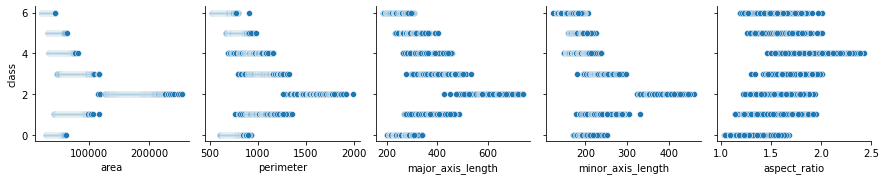

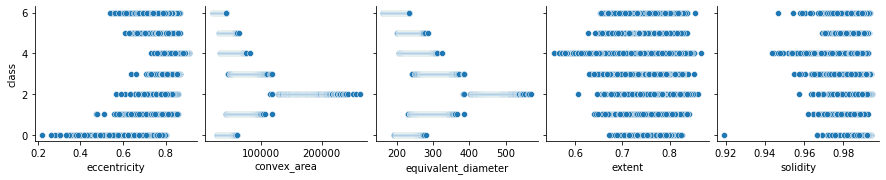

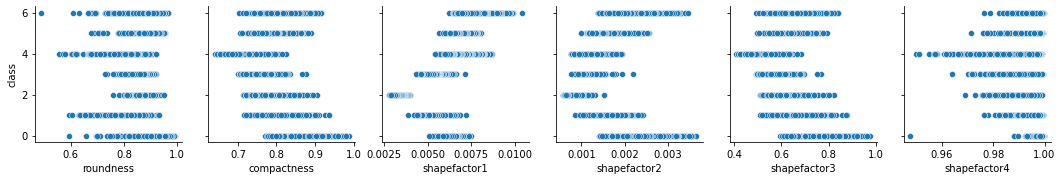


Clean the data

Split the data, dependent variable  16 , to keep  2
2
training data shape 
 (2678, 16) 
training data max, min, mean, var
              0             1            2           3         4         5   \
0  7.816100e+04   1273.205000   428.923013  275.578682  1.950371  0.858554   
1  2.839500e+04    610.291000   200.524796  171.210559  1.024868  0.218951   
2  4.913837e+04    831.327546   290.182184  212.553144  1.355279  0.645806   
3  2.165389e+08  25206.644444  3622.397338  449.878050  0.032398  0.011477   

             6            7         8         9         10        11  \
0  8.029200e+04   315.464223  0.840577  0.994213  0.990685  0.987303   
1  2.871500e+04   190.141097  0.639787  0.919246  0.593708  0.714494   
2  4.981756e+04   247.469059  0.763268  0.987397  0.890639  0.863290   
3  2.280371e+08  1323.978325  0.000942  0.000025  0.006423  0.003040   

             12            13        14        15  
0  7.474432e-03  3.664972e-03  0.974767  0.999733  
1  4

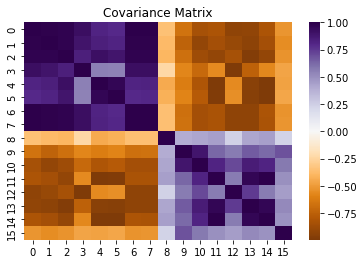

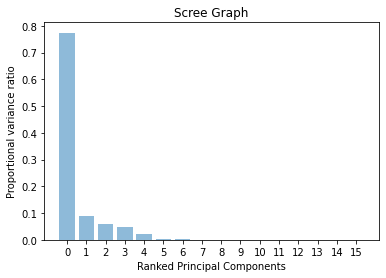

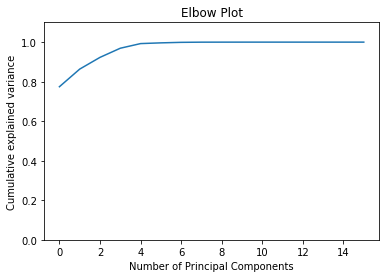

In [17]:
transformedTrain, transformedDev, transformedTest, trainY, devY, testY = prepData(type="classification", depVar=16, fractionToKeep=2)
projectedTrain, projectedDevTest = projectData(transformedTrain, 5, transformedDev, transformedTest)

In [ ]:
%%time

# Get the number of prototypes; this is hyperparameter tuning

rbf = RBFNetwork(type="classification")
rbf.explorePrototypes(transformedTrain, 2, 40, 2)

In [19]:
%%time

rbf = RBFNetwork(type="classification")

rbf.fit(transformedTrain, trainY, 36)
yhat = rbf.predict(transformedDev)
rbf.score(devY, yhat)

Wall time: 11.1 s


0.9850746268656716

In [ ]:
%%time

# Get the number of prototypes; this is hyperparameter tuning

rbf = RBFNetwork(type="classification")
rbf.explorePrototypes(projectedTrain, 2, 40, 2)

In [20]:
%%time

rbf = RBFNetwork(type="classification")

rbf.fit(projectedTrain, trainY, 36)
yhat = rbf.predict(projectedDevTest[0])
rbf.score(devY, yhat)

Wall time: 7.39 s


0.9880597014925373